<a href="https://colab.research.google.com/github/LukmaanViscomi/AI-Deep-Learning/blob/main/Baseline_Controlled_V6_0-96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip The Data

In [ ]:
### Section 1: Setup and Dependencies
!apt-get install p7zip-full # Install 7-Zip
!pip install patool # Install the patool library which provides the patoolib module
import zipfile
import os
import patoolib # Now you can import patoolib

# Path to the uploaded zip file
zip_file_path = '/content/drive/MyDrive/dataset2 (1).zip'
extracted_folder_path = './dataset2'  # Use a relative path for the extraction directory

# Extract the zip file using patool
patoolib.extract_archive(zip_file_path, outdir=extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

### Section 2 : Inspecting the Original Dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.5 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO:patool:Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO patool: ... creating output directory `./dataset2'.
INFO:patool:... creating output directory `./dataset2'.
INFO patool: running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO:patool:running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.
INFO:patool:... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.


['triple_mnist']


### Redistribute The Dataset For Train/Val/Test

In [ ]:
#
import os
import shutil
from pathlib import Path
import random

# Paths to original directories
original_base_dir = Path('dataset2/triple_mnist')
original_train_dir = original_base_dir / 'train'
original_val_dir = original_base_dir / 'val'
original_test_dir = original_base_dir / 'test'

# Path to the new dataset directory
new_base_dir = Path('dataset-c/triple_mnist')
new_train_dir = new_base_dir / 'train'
new_val_dir = new_base_dir / 'val'
new_test_dir = new_base_dir / 'test'

# Ensure the new directories exist
new_train_dir.mkdir(parents=True, exist_ok=True)
new_val_dir.mkdir(parents=True, exist_ok=True)
new_test_dir.mkdir(parents=True, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, new_train_dir, new_val_dir, new_test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not src_dir.exists():
        return

    classes = sorted(os.listdir(src_dir))

    for cls in classes:
        cls_path = src_dir / cls
        if cls_path.is_dir():
            images = list(cls_path.glob('*'))
            random.shuffle(images)

            num_train = int(len(images) * train_ratio)
            num_val = int(len(images) * val_ratio)

            train_images = images[:num_train]
            val_images = images[num_train:num_train+num_val]
            test_images = images[num_train+num_val:]

            cls_train_dir = new_train_dir / cls
            cls_val_dir = new_val_dir / cls
            cls_test_dir = new_test_dir / cls

            cls_train_dir.mkdir(parents=True, exist_ok=True)
            cls_val_dir.mkdir(parents=True, exist_ok=True)
            cls_test_dir.mkdir(parents=True, exist_ok=True)

            for img in train_images:
                shutil.copy(str(img), str(cls_train_dir / img.name))
            for img in val_images:
                shutil.copy(str(img), str(cls_val_dir / img.name))
            for img in test_images:
                shutil.copy(str(img), str(cls_test_dir / img.name))

# Split and copy files from original train, val, and test directories
split_and_copy_files(original_train_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_val_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_test_dir, new_train_dir, new_val_dir, new_test_dir)

print("Files split and copied successfully!")

Files split and copied successfully!


### Imports and Initial Setup -Define Directory

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight



### Data Generators for the Subset

In [ ]:
# Define directories for training, validation, and testing datasets
train_dir = os.path.join('/content/dataset-c/triple_mnist/train')
val_dir = os.path.join('/content/dataset-c/triple_mnist/val')
test_dir = os.path.join('/content/dataset-c/triple_mnist/test')

# Image size and batch size
image_size = (42, 42)
batch_size = 32

# Create ImageDataGenerator with color_mode set to 'grayscale'
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images with 'grayscale' mode
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

Found 60000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.


### Build the model

25-8-2024: 18:45...ok this is completely new code run. we ave left out the data augmentation. so with the exising 93% result we are just looking to use the keras hypeeband tuner to see if it can fins a best hyperparamater mix to get up past 93%

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


Trial 30 Complete [00h 11m 28s]
val_accuracy: 0.9355499744415283

Best val_accuracy So Far: 0.9560999870300293
Total elapsed time: 02h 13m 38s
Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9738 - loss: 0.0774 - val_accuracy: 0.9360 - val_loss: 0.2841 - learning_rate: 0.0013
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9600 - loss: 0.1190 - val_accuracy: 0.9336 - val_loss: 0.2775 - learning_rate: 0.0013
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9634 - loss: 0.1095 - val_accuracy: 0.9345 - val_loss: 0.2668 - learning_rate: 0.0013
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9647 - loss: 0.1065 - val_accuracy: 0.9347 - val_loss: 0.2791 - learning_rate: 0.0013
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9672 - loss: 0.0987 - val_accuracy: 0.9375 - val_loss: 0.2771 - learning_rate: 0.0013
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9695 - 

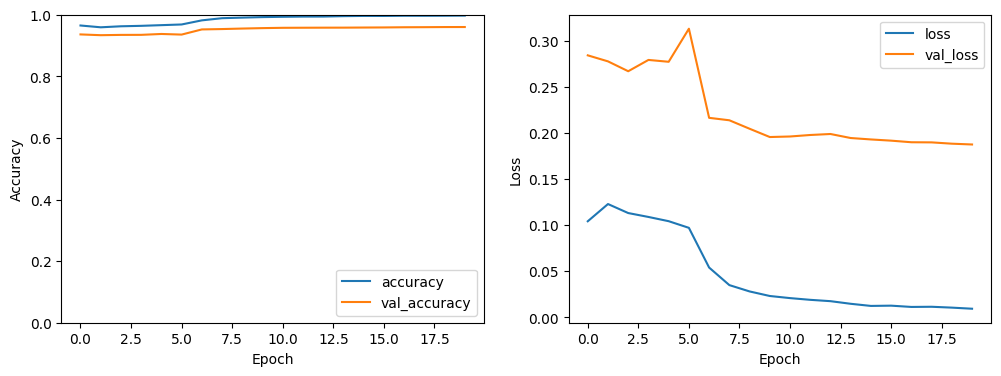

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9654 - loss: 0.1548
Test accuracy: 0.9621


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()

    # Hyperparameters to tune
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64])  # Adding batch size as a hyperparameter
    hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'sigmoid', 'tanh'])  # Adding activation function as a hyperparameter

    # First convolutional layer
    model.add(Conv2D(hp_filters_1, (3, 3), input_shape=(42, 42, 1)))
    if hp_activation == 'leaky_relu':
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    else:
        model.add(tf.keras.layers.Activation(hp_activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(hp_filters_2, (3, 3)))
    if hp_activation == 'leaky_relu':
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    else:
        model.add(tf.keras.layers.Activation(hp_activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(hp_dense_units))
    if hp_activation == 'leaky_relu':
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    else:
        model.add(tf.keras.layers.Activation(hp_activation))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout_rate))

    # Output layer
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Run the hyperparameter search
tuner.search(train_generator,
             epochs=20,
             validation_data=val_generator,
             callbacks=[early_stopping, reduce_lr])

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Train the model with the best hyperparameters on the full dataset
history = best_model.fit(train_generator,
                         epochs=20,
                         validation_data=val_generator,
                         callbacks=[early_stopping, reduce_lr])


# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
